# Diabetes Prediction Project

In this project, we addressed a supervised learning machine learning problem using a dataset related to diabetes. The dataset, originating from the National Institute of Diabetes and Digestive and Kidney Diseases, aims to predict whether a patient has diabetes based on diagnostic measurements.

[Kaggle Dataset](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset)

In the below cell we will be importing all the relevant packages

In [1]:

import pandas as pd
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from joblib import dump, load

# Load the Dataset

In [2]:
diabetes_df = pd.read_csv(r'Data\diabetes.csv')
diabetes_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Part I : EDA - Exploratory Data Analysis

For this task, we will be conducting an exploratory data analysis on the diabetes dataset. We will try to cover the following tasks:

- Are there any missing values in the dataset?
- How are the predictor variables related to the outcome variable?
- What is the correlation between the predictor variables?
- What is the distribution of each predictor variable?
- Are there any outliers in the predictor variables?
- How are the predictor variables related to each other?
- Is there any interaction effect between the predictor variables?
- What is the average age of the individuals in the dataset?
- What is the average glucose level for individuals with diabetes and without diabetes?
- What is the average BMI for individuals with diabetes and without diabetes?
- How does the distribution of the predictor variables differ for individuals with diabetes and without diabetes?
- Are there any differences in the predictor variables between males and females (if gender information is available)?

### In the below cell we will cover the following sub-tasks within EDA - 

Question 1. Check for missing values

Question 2. How are the predictor variables related to the outcome variable ? (To answer this question we will convert the Outcome data type to Categorical and showcase the underlying relationship through Boxplots and Statistical tests (T-Test in this case). Note that there are outliers that haven't been treated yet. )

Pregnancies


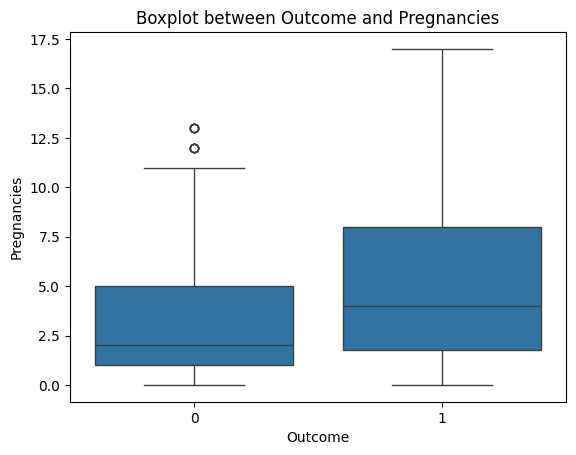

T-Test results between Pregnancies and Outcome
T-Statistic: 6.298430550035151
P-Value: 5.065127298053476e-10
Glucose


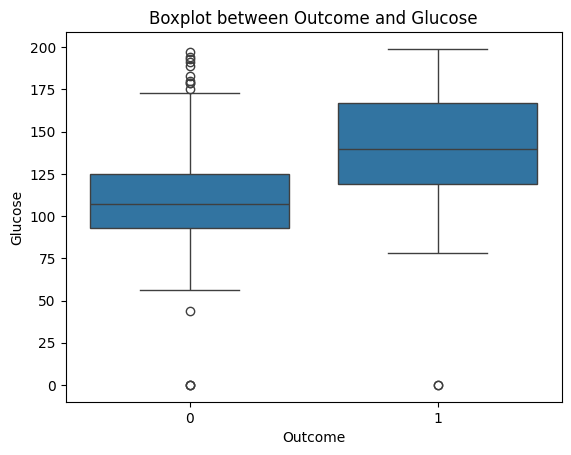

T-Test results between Glucose and Outcome
T-Statistic: 14.600060005973894
P-Value: 8.935431645289913e-43
BloodPressure


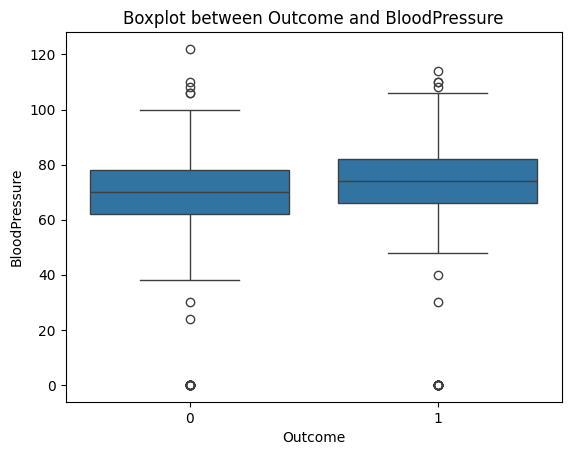

T-Test results between BloodPressure and Outcome
T-Statistic: 1.8047023017353887
P-Value: 0.07151390009776082
SkinThickness


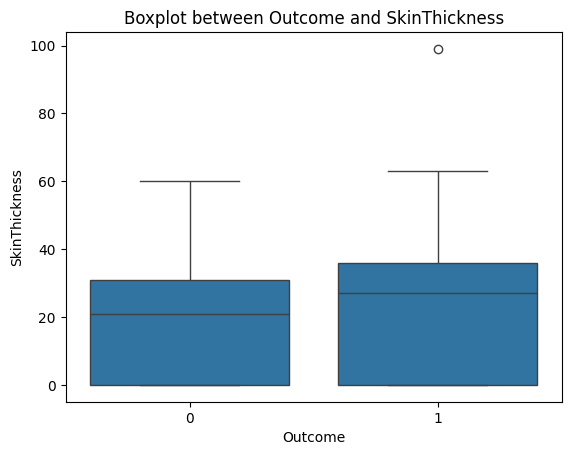

T-Test results between SkinThickness and Outcome
T-Statistic: 2.0747001964159613
P-Value: 0.03834770482049123
Insulin


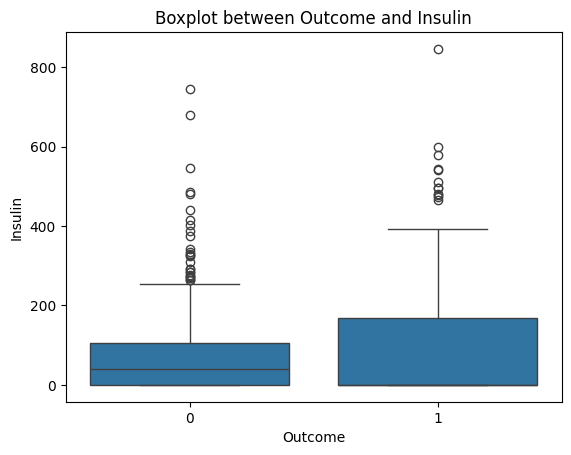

T-Test results between Insulin and Outcome
T-Statistic: 3.64432538765356
P-Value: 0.00028618646036031987
BMI


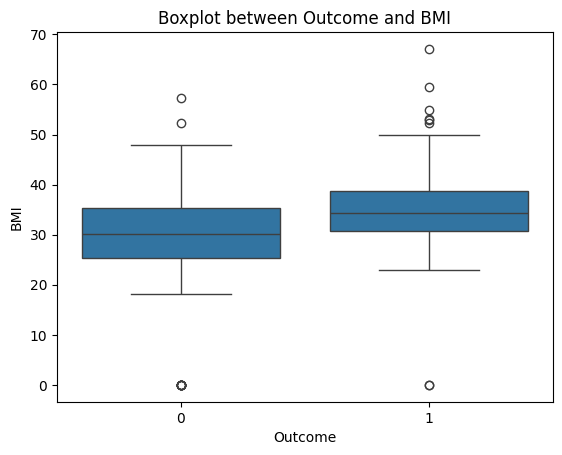

T-Test results between BMI and Outcome
T-Statistic: 8.47183994786525
P-Value: 1.2298074873116022e-16
DiabetesPedigreeFunction


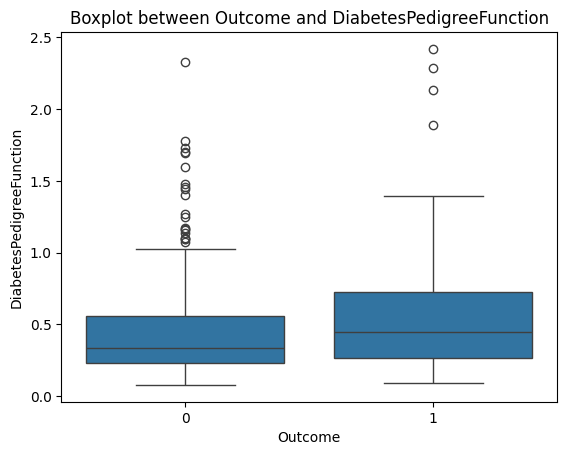

T-Test results between DiabetesPedigreeFunction and Outcome
T-Statistic: 4.88582646072744
P-Value: 1.254607010148809e-06
Age


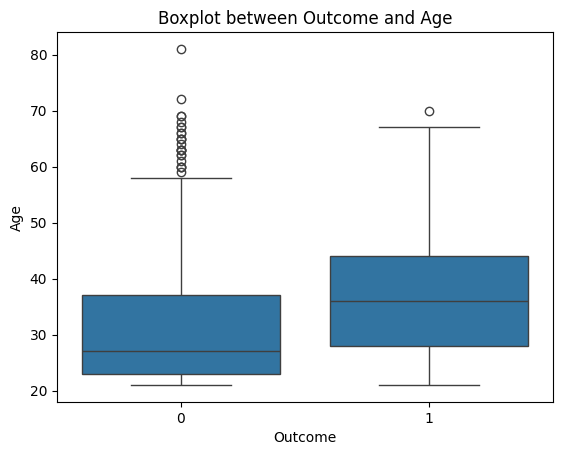

T-Test results between Age and Outcome
T-Statistic: 6.792688071649956
P-Value: 2.2099754606654358e-11


In [3]:
# Check for missing values

diabetes_df.isna().sum() # No missing values found
(diabetes_df == '').sum() # No missing values found

diabetes_df.Outcome = diabetes_df.Outcome.astype('category')

# Statistical Tests and Box plots

numeric_columns = diabetes_df.select_dtypes(include = ['int64', 'float64']).columns 

for i in numeric_columns:
    print(i)
    sns.boxplot(data = diabetes_df, x = diabetes_df.Outcome, y = diabetes_df[i])
    plt.title(f'Boxplot between Outcome and {i}')
    plt.show()

    diabetes_1 = diabetes_df[diabetes_df.Outcome == 1][i]
    diabetes_0 = diabetes_df[diabetes_df.Outcome != 1][i]

    # we will be doing independent t test as the sample lengths are different
    t_statistic, p_value = ttest_ind(diabetes_1, diabetes_0)
    print(f'T-Test results between {i} and Outcome')
    print(f'T-Statistic: {t_statistic}')
    print(f'P-Value: {p_value}')

### Findings on missing values and relationship of independent variables with the dependent variable - 
- There are no missing values
- All except the blood pressure are statistically significant with respect to the Outcome variable (Similar pattern can be witnessed in box plots as well)

### In the below cell, we will be answering following questions - 

Question 3 - What is the correlation between the predictor variables ?

Question 4 - What is the distribution of each predictor variable ?

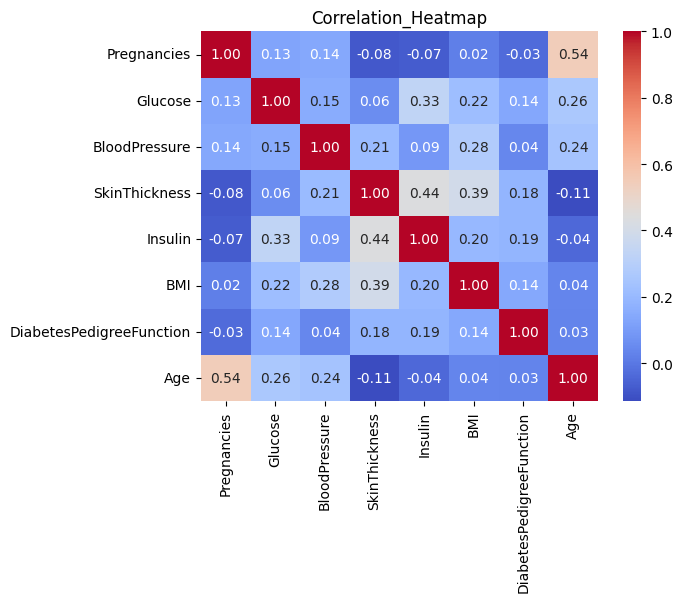

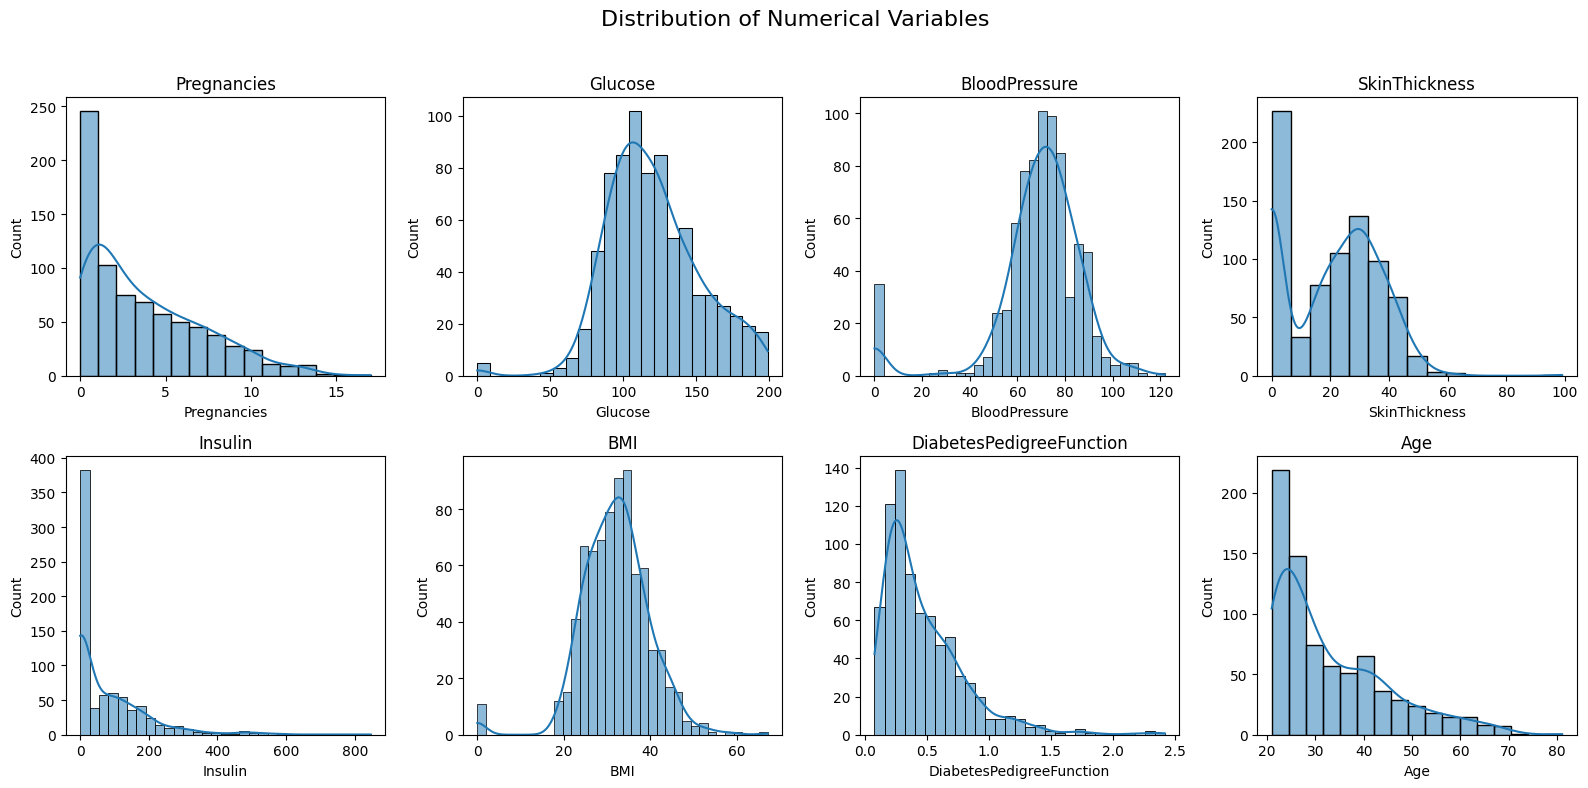

In [4]:

# Correlation
sns.heatmap(diabetes_df[diabetes_df.columns[diabetes_df.columns != 'Outcome']].corr(),
            annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation_Heatmap')
plt.show()


# Distribution
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Distribution of Numerical Variables', fontsize=16)

for i, col in enumerate(diabetes_df.columns[diabetes_df.columns != 'Outcome']):
    sns.histplot(diabetes_df[col], kde=True, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Findings on Correlation - 

- We can see that Pregnancy and Age are highly correlated
- And so are Insulin, BMI and Skinthickness but with a medium correlation

### Findings on Distribution - 

- Most of the data is skewed which means there will be outliers and thus scaling/normalization will be required for linear models and models relying on distance calculation like knn


### In the subsequent cells, we will be answering following questions -
Question 5. - Are there any outliers in the predictor variables? (to answer this we will print boxplots for each variable to show the outliers and use IQR to print the proportion of outliers in each column)   

Question 6. - How are the predictor variables related to each other? (Though this question has been already answered in Question 3 through correlation heatmap. Still we will create pairplot for reference. Even for Question 7 (Is there any interaction effect between the predictor variables?) nothing more is required after viewing the pairplot and correlations)


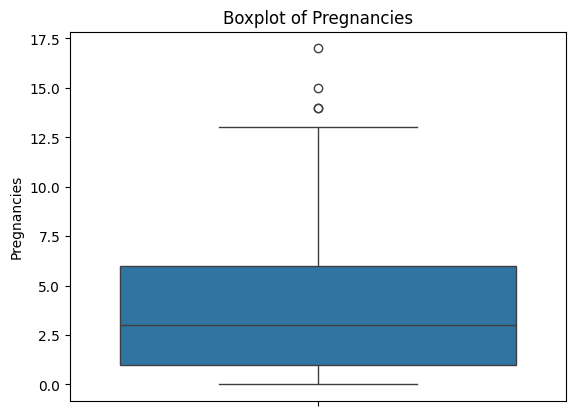

Proportion of outliers in Pregnancies: 0.52%



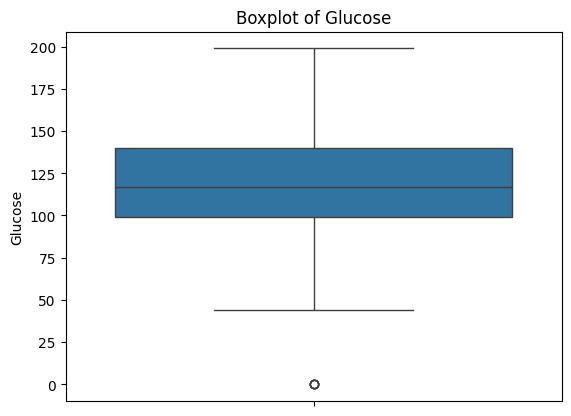

Proportion of outliers in Glucose: 0.65%



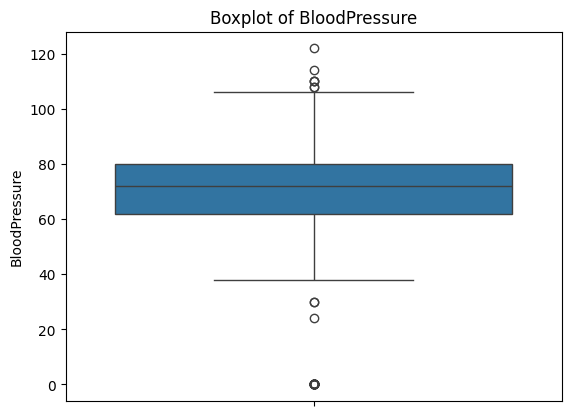

Proportion of outliers in BloodPressure: 5.86%



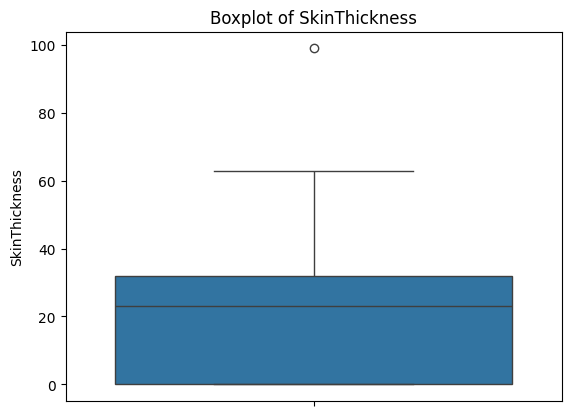

Proportion of outliers in SkinThickness: 0.13%



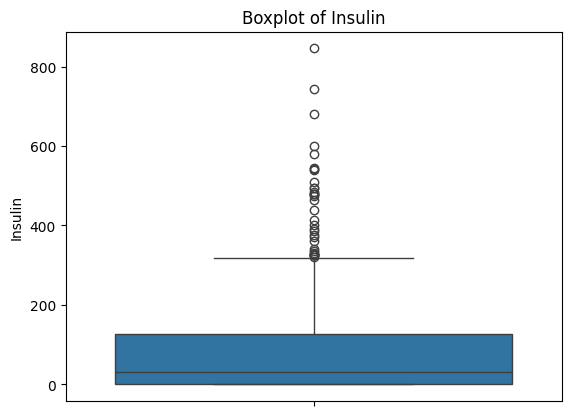

Proportion of outliers in Insulin: 4.43%



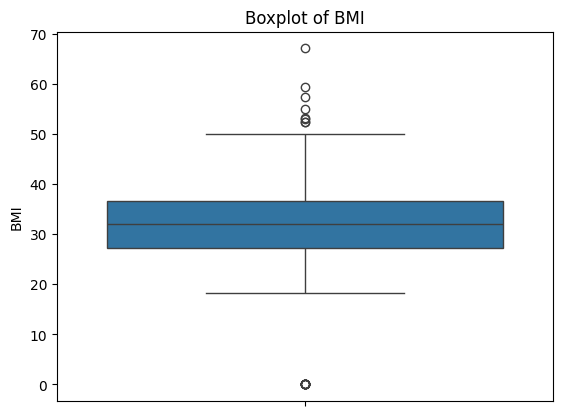

Proportion of outliers in BMI: 2.47%



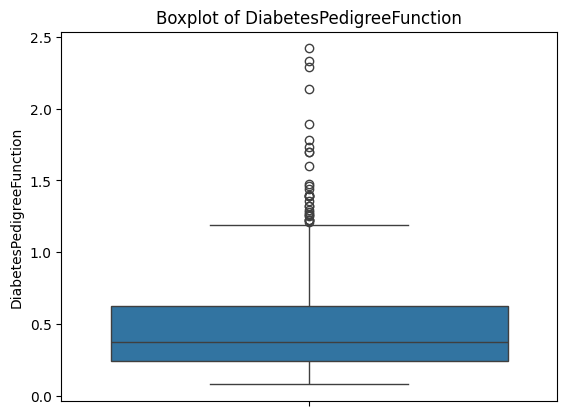

Proportion of outliers in DiabetesPedigreeFunction: 3.78%



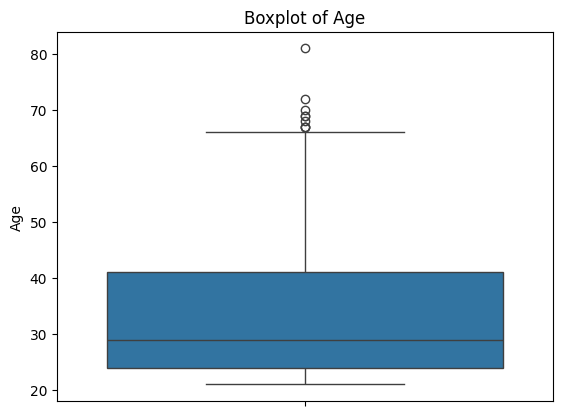

Proportion of outliers in Age: 1.17%



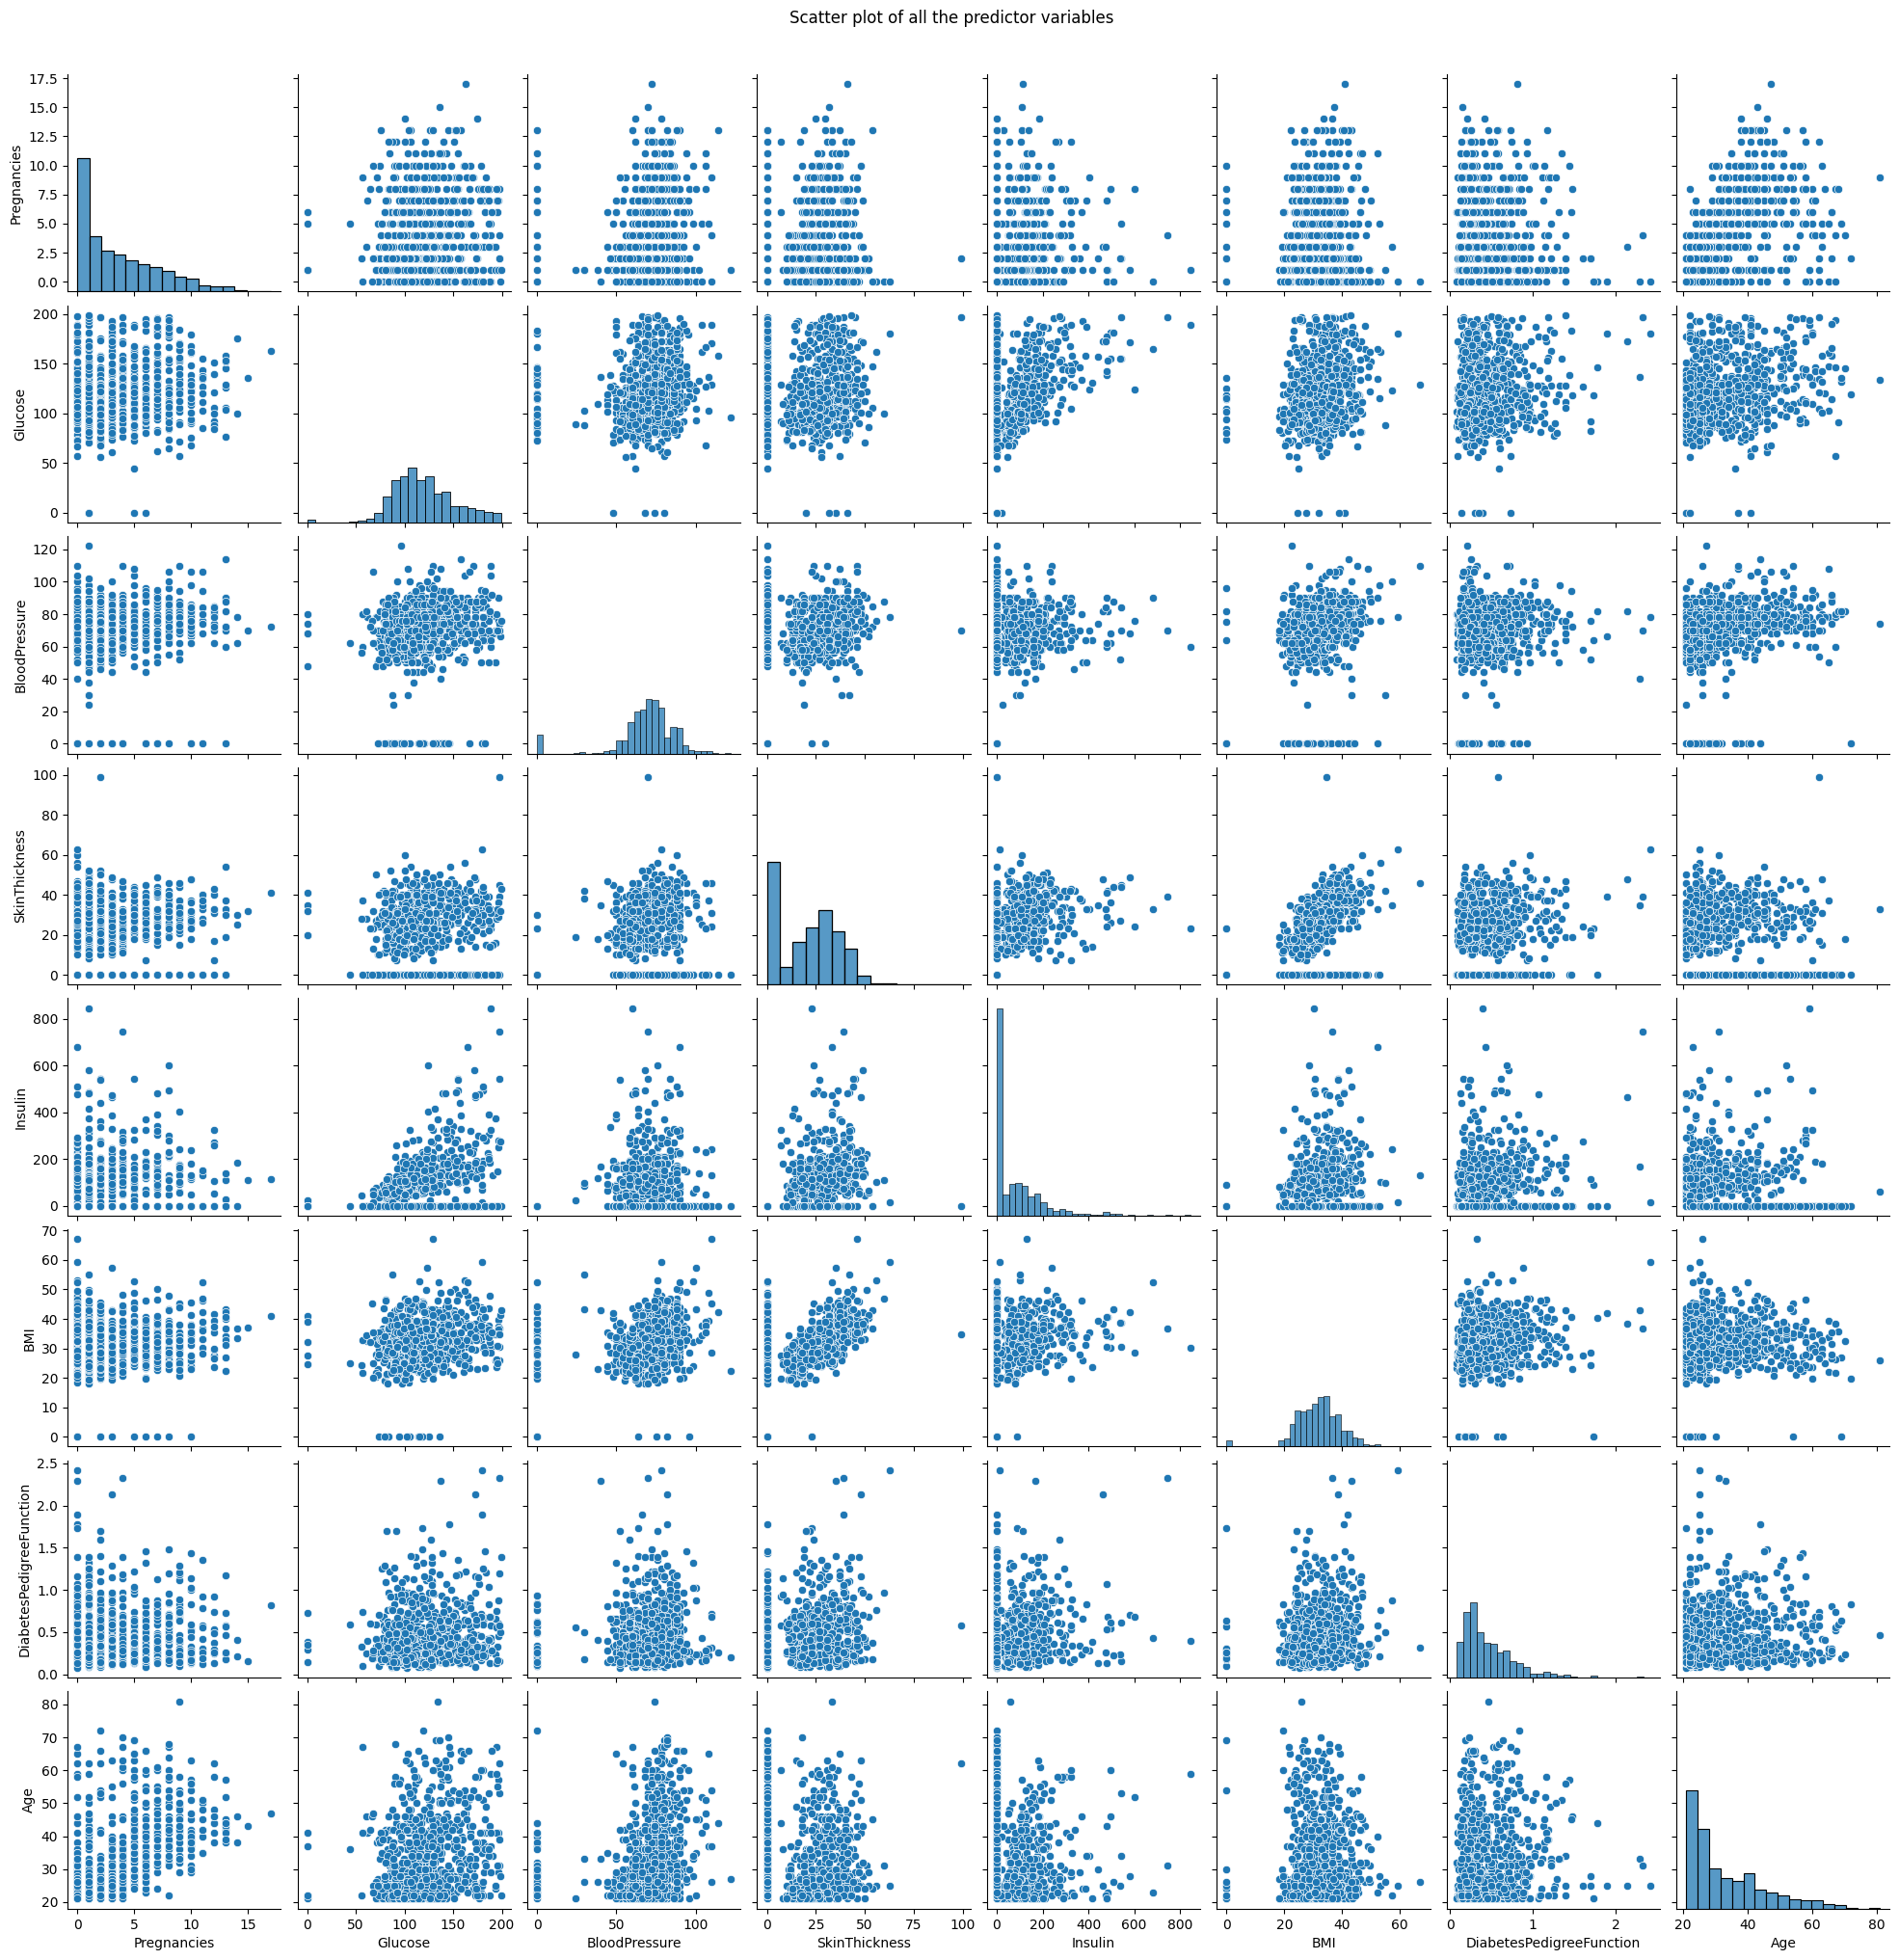

In [5]:
# Print Boxplots and proportion of outliers in each column
numeric_columns = diabetes_df.select_dtypes(include = ['int64', 'float64']).columns
for i in numeric_columns:
    sns.boxplot(data = diabetes_df, y = diabetes_df[i])
    plt.title(f'Boxplot of {i}')
    plt.show()

    q1 = diabetes_df[i].quantile(0.25)
    q3 = diabetes_df[i].quantile(0.75)
    outliers_count = ((diabetes_df[i] < q1 - 1.5 * (q3 - q1)) | (diabetes_df[i] > q3 + 1.5 * (q3 - q1))).sum()
    proportion_outliers = outliers_count / diabetes_df.shape[0]

    print(f'Proportion of outliers in {i}: {proportion_outliers:.2%}\n')

# Pairplot for checking relationship amongst variables
predictor_df = diabetes_df.select_dtypes(include = ['int64', 'float64'])
sns.pairplot(predictor_df)
plt.suptitle('Scatter plot of all the predictor variables', y =1.02)
plt.show()

### Findings on relations between predictor variables and outliers

- There aren't many outliers in the dataset, majority are less than 3%. Most outliers are in Blood pressure and Insulin.
- As observed in correlation plot, not significant pattern observed in pairplots

### In the subsequent cells we will be answering following questions - 

Question - 8. What is the average age of the individuals in the dataset?

Question - 9. What is the average glucose level for individuals with diabetes and without diabetes?

Question - 10. What is the average BMI for individuals with diabetes and without diabetes?

Question - 11. How does the distribution of the predictor variables differ for individuals with diabetes and without diabetes?
(Since we have already viewed the boxplot and statistical tests we will be comparing the 2 through the histplot)

Question - 12. Are there any differences in the predictor variables between males and females (if gender information is available)? (We do not have gender information but we can use Pregnancy as an indicator. Though the practice seems to be flawed as there might be women with 0 pregnancy and still having diabetes but for the concerned question we will be creating a gender column for analysis. Please note this column will not be used in model building.)

Average age in the dataset is 33
Average glucose in patients with diabetes is 141
Average glucose in patients without diabetes is 110
Average BMI in patients with diabetes is 35
Average BMI in patients without diabetes is 30


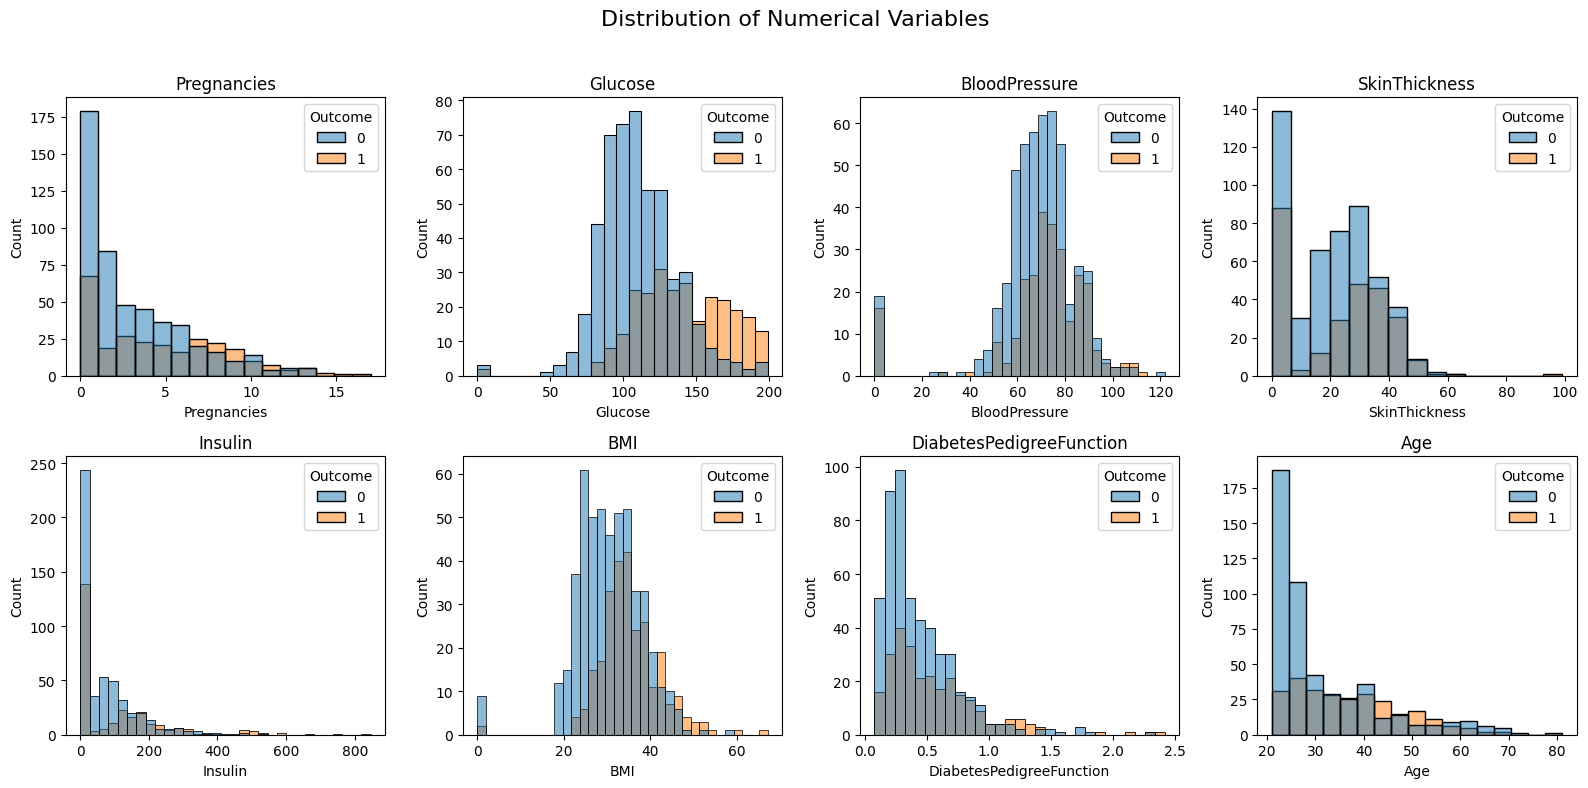

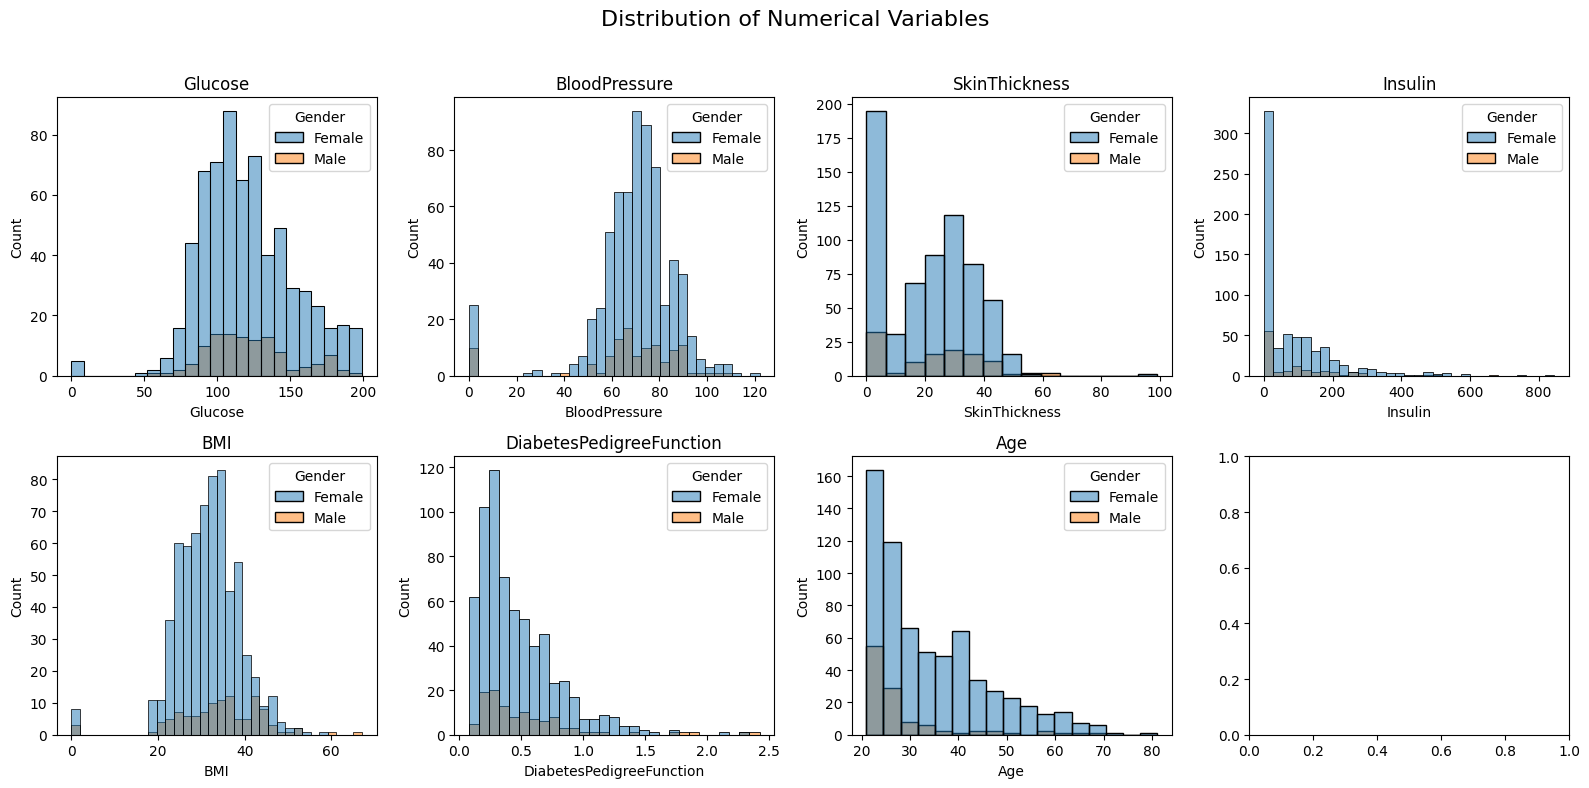

In [6]:
### Average Age
print(f'Average age in the dataset is {round(diabetes_df.Age.mean())}')

### Average Glucose Levels
print(f'Average glucose in patients with diabetes is {round(diabetes_df.Glucose[diabetes_df.Outcome == 1].mean())}')
print(f'Average glucose in patients without diabetes is {round(diabetes_df.Glucose[diabetes_df.Outcome != 1].mean())}')

### Average BMI
print(f'Average BMI in patients with diabetes is {round(diabetes_df.BMI[diabetes_df.Outcome == 1].mean())}')
print(f'Average BMI in patients without diabetes is {round(diabetes_df.BMI[diabetes_df.Outcome != 1].mean())}')

### Distribution comparison

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Distribution of Numerical Variables', fontsize=16)

for i, col in enumerate(diabetes_df.columns[diabetes_df.columns != 'Outcome']):
    sns.histplot(data = diabetes_df, x = diabetes_df[col], hue = 'Outcome', kde=False, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
 
### Comparison of diabetes across gender

diabetes_df['Gender'] = np.where(diabetes_df.Pregnancies == 0, 'Male', 'Female')

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Distribution of Numerical Variables', fontsize=16)

for i, col in enumerate(diabetes_df.columns[~diabetes_df.columns.isin(['Outcome', 'Pregnancies', 'Gender'])]):
    sns.histplot(data = diabetes_df, x = diabetes_df[col], hue = 'Gender', kde=False, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

diabetes_df.drop(columns='Gender', inplace=True)


### Findings from Distribution Analysis - 

- Female patients with pregnancy in past tend to be more likely to have diabetes
- Higher glucose is associated with high likelihood of Diabetes
- Likelihood of Diabetes increases with Age


# Part II : Preprocessing & Feature Engineering

### In the subsequent cell we will be covering following activities -

Question - 12. Handling Missing Values 

Question - 13. Handling Outliers

Question - 14. Scaling and normalization (We will scale the variables that follow a normal distribution. Wherever we do not have a normal distribution then we will use methods like Box Cox Transformation, Log transformation etc to make the distribution normal. To test for normality we will use shapiro wilk test. Please note had the sample size > 5K then we could not have used shapiro test)

Question - 15. Feature Engineering (Right now we will skip this step, as most of the feature engineering is done. After fitting the model if we have low accuracy and recall then we can use PCA to fit the model. )

Question - 16. Handling class imbalance (Despite the fact that we will be fitting random forest and SVM, and that both are capable of dealing with class imbalance, still we will treat the class imbalance using SMOTE and try to fit the same models again.)

 
### Note on Preprocessing - 
Before we do any preprocessing on the dataset, we will have to divide the dataframe into test and train to avoid any involuntary data leakage into the model. For steps like outlier capping, scaling and missing value imputation it is of paramount significance that we divide the data before any preprocessing. 


In [7]:

# Load the dataset

diabetes_df = pd.read_csv(r'Data\diabetes.csv')
diabetes_df.head(5)

# Change data type

diabetes_df.Outcome = diabetes_df.Outcome.astype('category')


# Divide into test and train

X_train, X_test, y_train, y_test = train_test_split(diabetes_df[diabetes_df.columns[diabetes_df.columns != 'Outcome']], 
                                                    diabetes_df['Outcome'], 
                                                    test_size=0.2, 
                                                    random_state=42)

### Checking and treating Missing Values 

print(X_train.isna().sum())
print((X_train == '').sum())

print(X_test.isna().sum())
print((X_test == '').sum())

print(y_train.isna().sum())
print((y_train == '').sum())

print(y_test.isna().sum())
print((y_test == '').sum())

### Outlier Treatment 

numeric_columns = diabetes_df.select_dtypes(include = ['int64', 'float64']).columns

for i in numeric_columns:
    
    # Outlier Capping for training set
    X_train[i] = X_train[i].clip(lower=X_train[i].quantile(0.05))
    X_train[i] = X_train[i].clip(upper=X_train[i].quantile(0.95))

    # Outlier Capping for test set
    X_test[i] = X_test[i].clip(lower=X_train[i].quantile(0.05))
    X_test[i] = X_test[i].clip(upper=X_train[i].quantile(0.95))


### Scaling and Normalization

predictor_df = diabetes_df.select_dtypes(include = ['float64', 'int64']).columns
for i in predictor_df:
    print(shapiro(diabetes_df[i])) # Since all the variables have a p value < 0.05
                                   # we will just scale all the data points 
    
# Scaling for test and train shall be done separately
    
scaler = StandardScaler()
X_train[predictor_df] = scaler.fit_transform(X_train[predictor_df])
X_test[predictor_df] = scaler.transform(X_test[predictor_df]) # Test set will be transformed using training set parameters

print(y_train.value_counts())
print(y_test.value_counts())

# For class imbalance we will use SMOTE 

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(X_train_balanced.shape)
print(y_train_balanced.value_counts())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
d

### Findings -

- No missing values found
- Separately imputed the outliers in train and test data set through outlier capping
- Scaling and Normalization - Checked for normal distribution of variables through Shapiro test. All were found to have a significant p value and hence scaled them using standard scaler for faster model convergence. 
- Checked for class imbalance and since there was class imbalance, created a set with Smote for separate modeling later if required.

# Part III : Training ML Model

In the subsequent cells, we will be building a machine learning model to predict the outcome variable. This will be a binary classification task, as the target variable is binary. We will select at least two models, one of which should be an ensemble model, and compare their performance.

Steps to be covered:

- Create a function to print model evaluation metrics and ROC curve
- Train the models: Train the selected models on the training set.
- Model evaluation: Evaluate the trained models on the testing set using appropriate evaluation metrics, such as accuracy, precision, recall, F1-score, and ROC-AUC.
- Model comparison: Compare the performance of the selected models and choose the best-performing model based on the evaluation metrics. If required we will perform additional analysis, such as model tuning and cross-validation, to improve the model's performance.

In [8]:
# Function for ROC Curve and Accuracy metrics

def evaluation_metrics(training_set_labels, test_set_labels, training_set_predictors,  test_set_predictors, 
                       ml_model, training_set_predictions, test_set_predictions):


    # Print Metrics on Training Data
    print("Training Accuracy:", accuracy_score(training_set_labels, training_set_predictions))
    print("Training Precision:", precision_score(training_set_labels, training_set_predictions))
    print("Training Recall:", recall_score(training_set_labels, training_set_predictions))
    print("Training F1-Score:", f1_score(training_set_labels, training_set_predictions))

    # Print Metrics on Test Data
    print("Test Accuracy:", accuracy_score(test_set_labels, test_set_predictions))
    print("Test Precision:", precision_score(test_set_labels, test_set_predictions))
    print("Test Recall:", recall_score(test_set_labels, test_set_predictions))
    print("Test F1-Score:", f1_score(test_set_labels, test_set_predictions))

    # Predict probabilities for the positive class (class 1)
    y_prob = ml_model.predict_proba(test_set_predictors)[:, 1]

    # Compute ROC curve and AUC
    fpr_balance, tpr_balance, thresholds_balance = roc_curve(test_set_labels, y_prob)
    roc_auc_balance = auc(fpr_balance, tpr_balance)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_balance, tpr_balance, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_balance:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Balanced Random Forest')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()



Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1-Score: 1.0
Test Accuracy: 0.7467532467532467
Test Precision: 0.6538461538461539
Test Recall: 0.6181818181818182
Test F1-Score: 0.6355140186915889


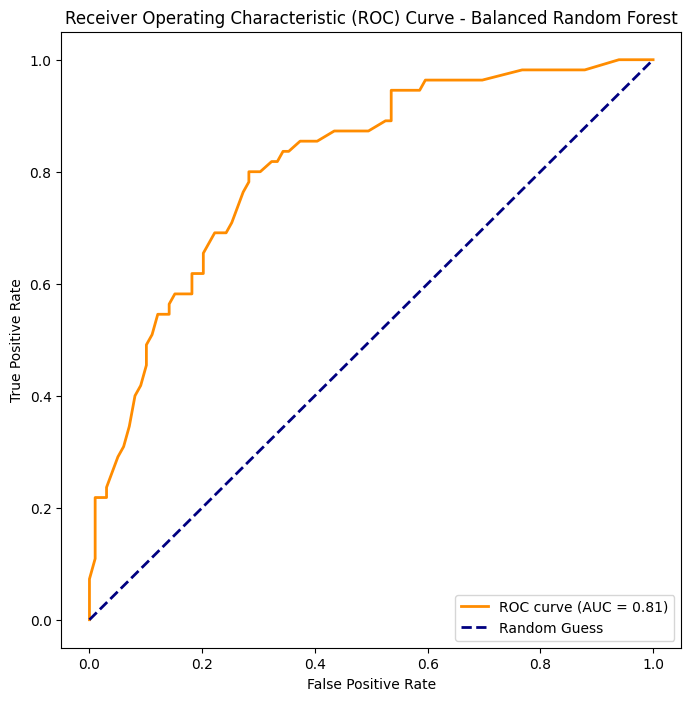

In [9]:
# Fit Random Forest on imbalanced set and print metrics
# Random Forest on Imbalanced Training Set
rf_imbalance = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_imbalance.fit(X_train, y_train)
y_pred_rf_imbalance = rf_imbalance.predict(X_test)

# Predictions on the Training Set
y_pred_train_rf_imbalance = rf_imbalance.predict(X_train)

# Print results
evaluation_metrics(y_train, y_test, X_train, X_test, rf_imbalance, y_pred_train_rf_imbalance, y_pred_rf_imbalance)

Model Performance Evaluation - 

We tried random forest model on an imbalanced data set initially, and in the results we can clearly see that the model is overfitting, as in the performance on training set is very high compared to that on test set. Probably the reason for overfitting is that the set count is very low (614 for train and 154 for test set). Thus, we will have to retrain the model with some tuning. 

Important Metrics to improve - 

Also, since we are trying to predict whether a patient has diabetes or not, and also due to the fact that the classes are imbalanced (Ratio of 1:2 between positive and negative classes respectively), ensuring that the Recall (true positive rate) is high is more important than other metrics. So we will aim at lifting the model recall without compromising much on the F1 score (harmonic mean of precision and recall)

#### In the below cell we will tune the Random Forest and see if we can achieve lift in recall

Training Accuracy: 0.7866449511400652
Training Precision: 0.6474820143884892
Training Recall: 0.8450704225352113
Training F1-Score: 0.7331975560081466
Test Accuracy: 0.6558441558441559
Test Precision: 0.5128205128205128
Test Recall: 0.7272727272727273
Test F1-Score: 0.6015037593984962


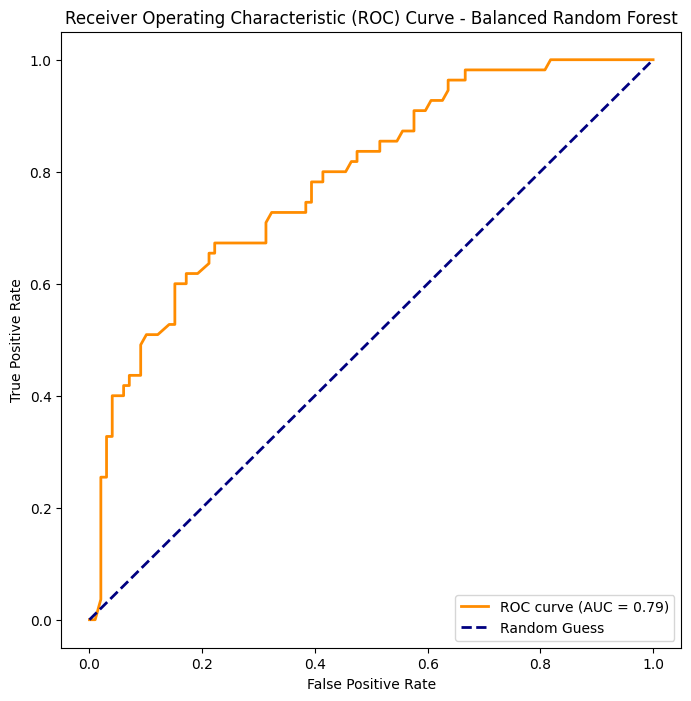

In [10]:
rf_imbalance = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_split=5, min_samples_leaf=10, 
                                      random_state=42, class_weight='balanced')
rf_imbalance.fit(X_train, y_train)
y_pred_rf_imbalance = rf_imbalance.predict(X_test)

# Predictions on the Training Set
y_pred_train_rf_imbalance = rf_imbalance.predict(X_train)

evaluation_metrics(y_train, y_test, X_train, X_test, rf_imbalance, y_pred_train_rf_imbalance, y_pred_rf_imbalance)



We were able to reduce the model overfitting by tuning the model on number of trees, maximum depth of each tree, min number of samples required for splitting an internal node and min smaples per leaf. Following were the model parameters passed - n_estimators=5, max_depth=3, min_samples_split=5, min_samples_leaf=10. 

Our model recall on training set dropped from 100% to 84% and our test recall increased from 62% to 73%, which is a good thing. 


In the subsequent cell we will train and test the model on balanced set. May be lack of class 1 data is leading to low Recall on test set. An alternative approach here can be of tweaking the threshold. We will try that later in case tuning and class balancing doesn't help.

Training Accuracy: 0.7905236907730673
Training Precision: 0.7594654788418709
Training Recall: 0.8503740648379052
Training F1-Score: 0.8023529411764706
Test Accuracy: 0.7272727272727273
Test Precision: 0.5942028985507246
Test Recall: 0.7454545454545455
Test F1-Score: 0.661290322580645


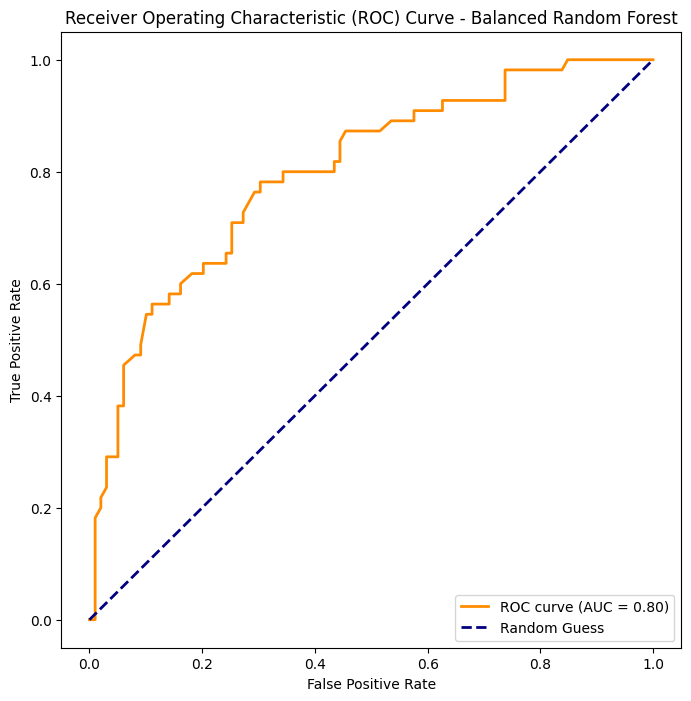

In [11]:
# Now we will test the tuned model on balanced dataset

rf_balance = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_split=5, min_samples_leaf=10, 
                                      random_state=42)
rf_balance.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balance = rf_balance.predict(X_test)

# Predictions on the Training Set
y_pred_train_rf_balance = rf_balance.predict(X_train_balanced)

evaluation_metrics(y_train_balanced, y_test, X_train_balanced, X_test, rf_balance, 
                   y_pred_train_rf_balance, y_pred_rf_balance)


With SMOTE optimized data sets (i.e. synthetic class balance treatment) we got a minor lift in our recall. The training recall went up from 84% to 85% and the test recall increased from 73% to 75%. Also, one more indirect effect of this was major lift in test precision (51% to 59%) and test accuracy (66% to 72%) compared to the last model. 

So far, we can conclude that hyperparameter tuning and class imbalance treatment has a significant positive effect on our model performance. 

In the below cell, we will try fitting a logistic regression model, to serve as a comparison model for random forest. Please note initially we will try to fit the model on imbalanced dataset and if the results are not satisfactory then we will try to fit it on balanced dataset. 

Training Accuracy: 0.7703583061889251
Training Precision: 0.6417322834645669
Training Recall: 0.7652582159624414
Training F1-Score: 0.6980728051391863
Test Accuracy: 0.6883116883116883
Test Precision: 0.5492957746478874
Test Recall: 0.7090909090909091
Test F1-Score: 0.6190476190476191


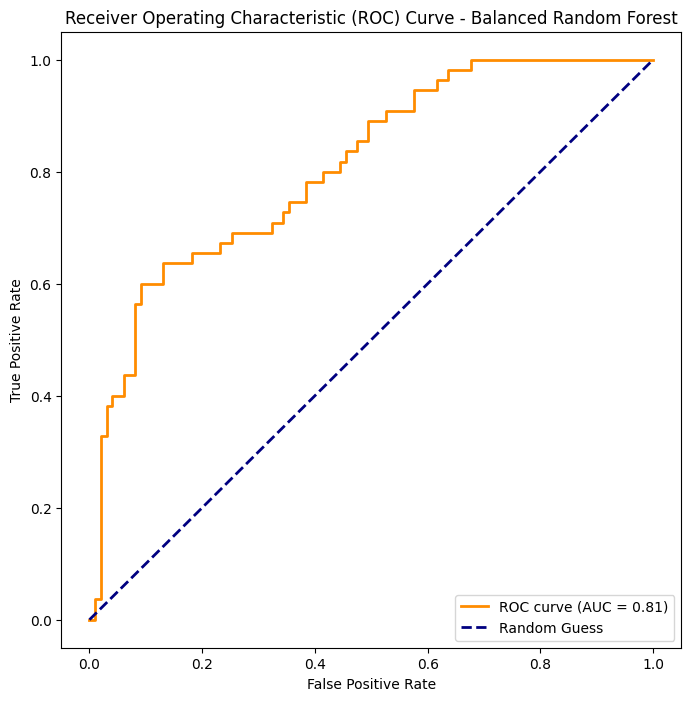

In [12]:
# Logistic Regression

# Logistic Regression on Imbalanced Training Set
log_reg_imbalance = LogisticRegression(random_state=42, class_weight='balanced')
log_reg_imbalance.fit(X_train, y_train)
y_pred_log_reg_imbalance = log_reg_imbalance.predict(X_test)

# Predictions on the Training Set
y_pred_train_log_reg_imbalance = log_reg_imbalance.predict(X_train)

evaluation_metrics(y_train, y_test, X_train, X_test, log_reg_imbalance, 
                   y_pred_train_log_reg_imbalance, y_pred_log_reg_imbalance)



As per the evaluation metrics of logistic regression on imbalanced dataset, we can conclude that the model is not overfitting, but it seems to have some bias (Recall train - 77%, Recall test - 71%, Accuracy train - 77%, Accuracy test - 69%). We will see if we can improve the model performance by training it on balanced set. 

Training Accuracy: 0.7768079800498753
Training Precision: 0.7775
Training Recall: 0.7755610972568578
Training F1-Score: 0.7765293383270911
Test Accuracy: 0.6753246753246753
Test Precision: 0.5352112676056338
Test Recall: 0.6909090909090909
Test F1-Score: 0.6031746031746031


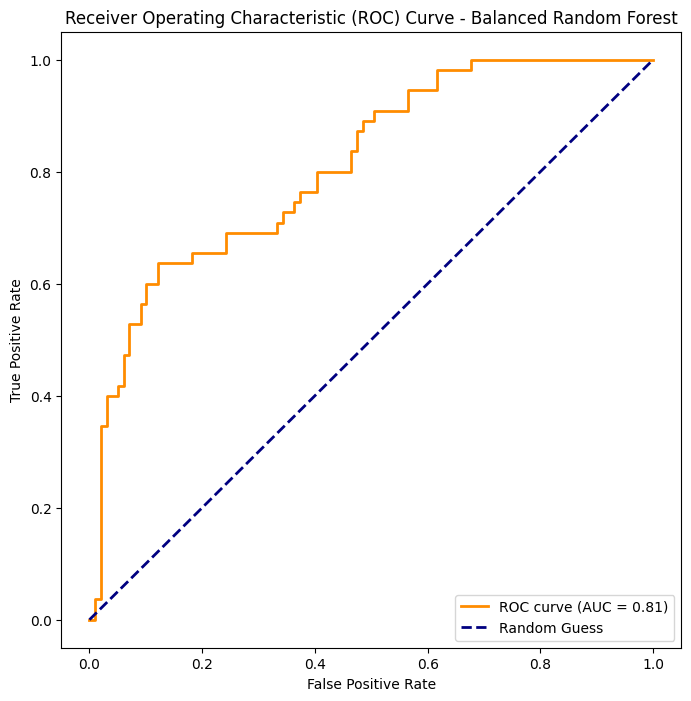

In [13]:
# Now we will fit the model on the balanced dataset

log_reg_balance = LogisticRegression(random_state=42)
log_reg_balance.fit(X_train_balanced, y_train_balanced)
y_pred_log_reg_balance = log_reg_balance.predict(X_test)

# Predictions on the Training Set
y_pred_train_log_reg_balance = log_reg_balance.predict(X_train_balanced)

# Print the evaluation metrics and the ROC curve
evaluation_metrics(y_train_balanced, y_test, X_train_balanced, X_test, log_reg_balance, 
                   y_pred_train_log_reg_balance, y_pred_log_reg_balance)


The model performance has dipped on test set after training it on balanced dataset. The recall on test set has dropped from 71% to 69%. Hence, we will try another model to see if we can get any better results. 

In the subsequent cell, we will try fitting an SVM to the training set. We will take the imbalanced training set initially. 

Training Accuracy: 0.8175895765472313
Training Precision: 0.6934865900383141
Training Recall: 0.8497652582159625
Training F1-Score: 0.7637130801687763
Test Accuracy: 0.7337662337662337
Test Precision: 0.6
Test Recall: 0.7636363636363637
Test F1-Score: 0.6719999999999999


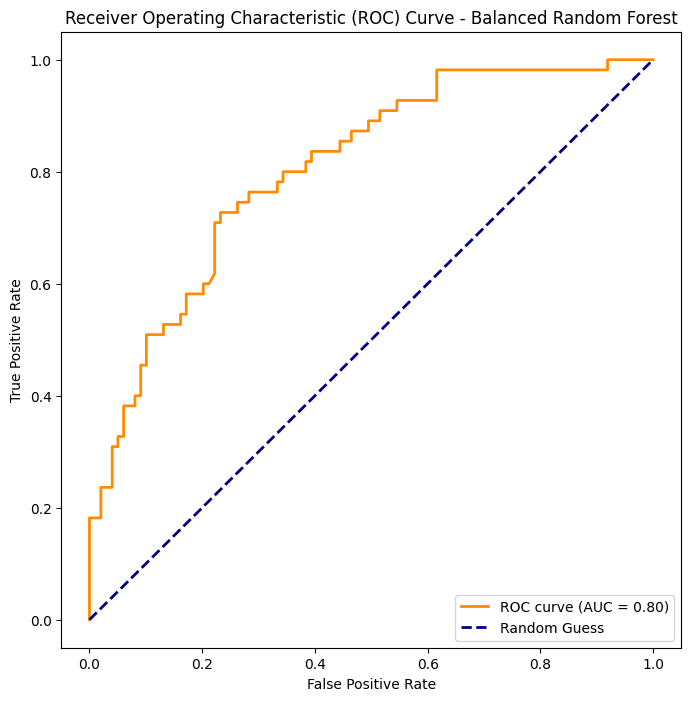

In [14]:
# Fit SVM on imbalanced set and print metrics
svm_imbalance = SVC(random_state=42, class_weight='balanced', probability=True)
svm_imbalance.fit(X_train, y_train)
y_pred_svm_imbalance = svm_imbalance.predict(X_test)

# Predictions on the Training Set
y_pred_train_svm_imbalance = svm_imbalance.predict(X_train)

# Print the evaluation metrics and the ROC curve
evaluation_metrics(y_train, y_test, X_train, X_test, svm_imbalance, 
                   y_pred_train_svm_imbalance, y_pred_svm_imbalance)


We got a very good performance with the SVM on the imbalanced dataset (Recall Training - 85%, Recall Test - 76%, Accuracy Training - 82% and Accuracy Test - 73%). SVM seems to outperform the Random forest and logistic regression. We will try to fit the model on balanced dataset and then try to optimize it with hyperparameter tuning. 

Training Accuracy: 0.8466334164588528
Training Precision: 0.830952380952381
Training Recall: 0.8703241895261845
Training F1-Score: 0.8501827040194885
Test Accuracy: 0.7077922077922078
Test Precision: 0.5694444444444444
Test Recall: 0.7454545454545455
Test F1-Score: 0.6456692913385828


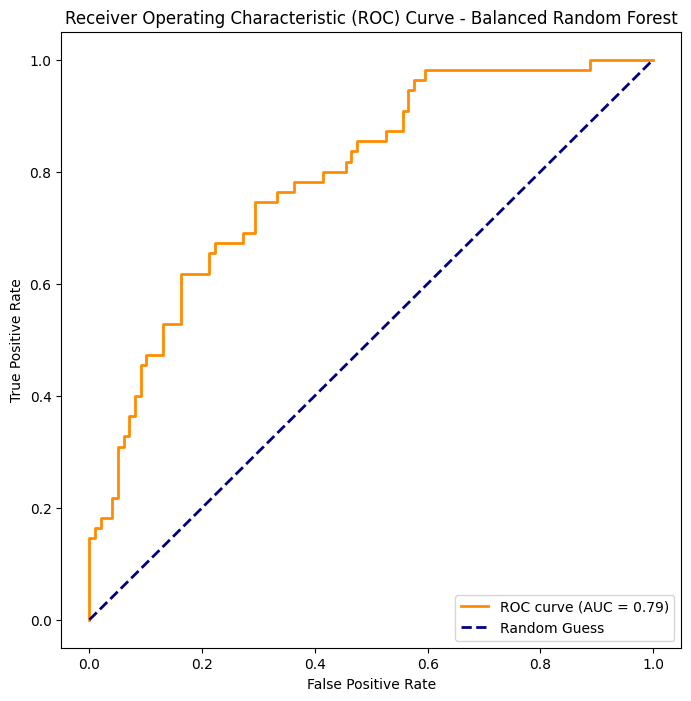

In [15]:

# Now we will test the tuned model on balanced dataset
svm_balance = SVC(random_state=42, probability=True)
svm_balance.fit(X_train_balanced, y_train_balanced)
y_pred_svm_balance = svm_balance.predict(X_test)

# Predictions on the Training Set
y_pred_train_svm_balance = svm_balance.predict(X_train_balanced)

# Print the evaluation metrics and the ROC curve
evaluation_metrics(y_train_balanced, y_test, X_train_balanced, X_test, svm_balance, 
                   y_pred_train_svm_balance, y_pred_svm_balance)

With balanced dataset our model performance dipped, test recall went down to 75% from 76% and test accuracy went down to 71% from 73%. Now we will use hyperparameter tuning (randomized search) on imbalanced dataset with SVM to see if we can lift the performance. 


Best Parameters: {'C': 7.896910002727692, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Training Accuracy: 0.8925081433224755
Training Precision: 0.893048128342246
Training Recall: 0.784037558685446
Training F1-Score: 0.8350000000000001
Test Accuracy: 0.7207792207792207
Test Precision: 0.62
Test Recall: 0.5636363636363636
Test F1-Score: 0.5904761904761904


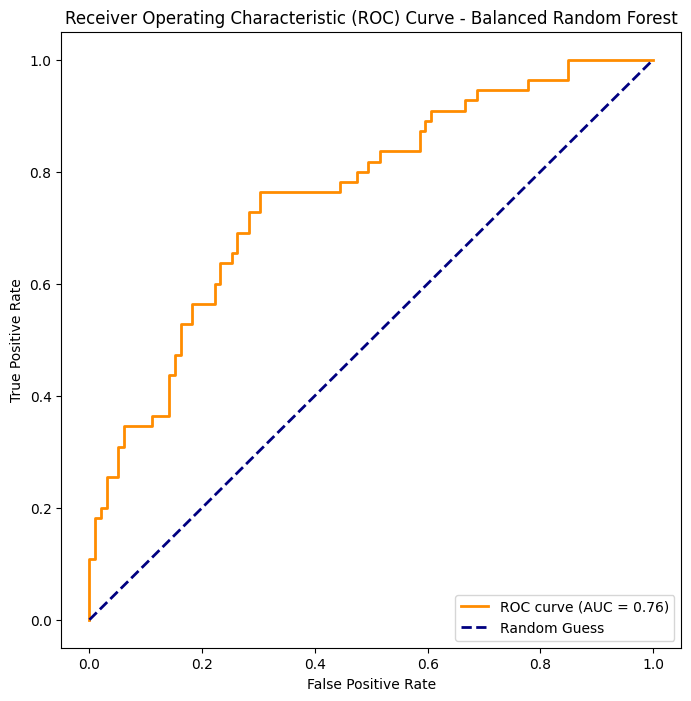

In [16]:
# Define the SVM model
svm_imbalance = SVC(random_state=42, probability=True)

# Specify the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': randint(2, 5),
    'gamma': ['scale', 'auto'],
}

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search = RandomizedSearchCV(
    svm_imbalance,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',  # Use 'recall' as the evaluation metric
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Access the best model
best_svm_imbalance = random_search.best_estimator_

# Predictions on the Training Set
y_pred_train_svm_imbalance = best_svm_imbalance.predict(X_train)

# Predictions on the Test Set
y_pred_test_svm_imbalance = best_svm_imbalance.predict(X_test)

# Print the evaluation metrics and the ROC curve
evaluation_metrics(y_train, y_test, X_train, X_test, best_svm_imbalance, 
                   y_pred_train_svm_imbalance, y_pred_test_svm_imbalance)

Tuning the SVM did not help at all, rather our test recall dropped to 56% from 75%. As a last attempt we will try to tune random forest and see if there is any performance lift, else we will have to go ahead with un-tuned SVM on trained on imbalanced dataset.  

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 72}
Training Accuracy: 0.8491271820448878
Training Precision: 0.8286384976525821
Training Recall: 0.8802992518703242
Training F1-Score: 0.8536880290205562
Test Accuracy: 0.7207792207792207
Test Precision: 0.581081081081081
Test Recall: 0.7818181818181819
Test F1-Score: 0.6666666666666666


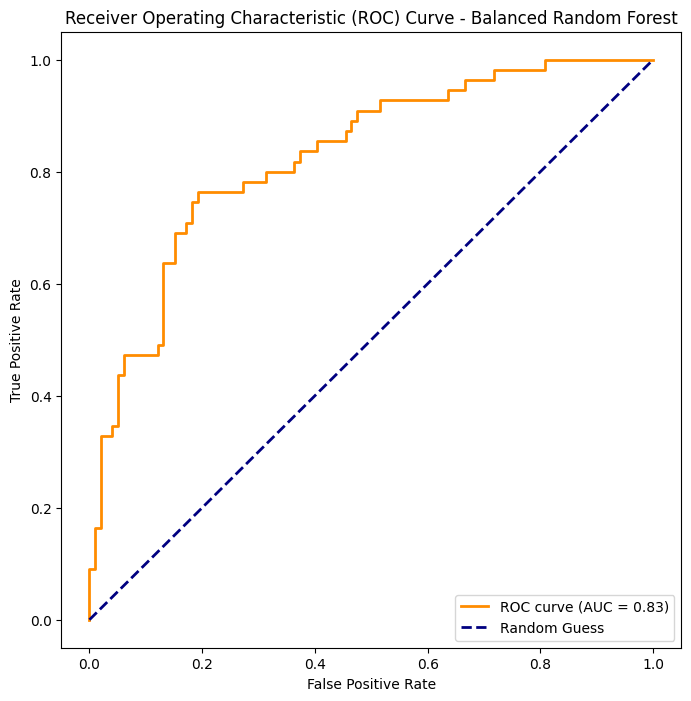

In [17]:
# After trying 3 models, we found out that Random forest seems to outperform other 2 models
# So we will be using random search to tune the hyperparameters of random forest and see it's performance

# Define the parameter grid
param_dist = {
    'n_estimators': randint(1, 100),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}

# Create a RandomForestClassifier
rf_balance = RandomForestClassifier(random_state=42) # Class weight balanced is not required since we are using balanced set

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_balance, 
    param_distributions=param_dist, 
    n_iter=10,  # Adjust the number of iterations as needed
    cv=5,  # Adjust the number of cross-validation folds as needed
    scoring='roc_auc',  # Use 'roc_auc' for binary classification
    random_state=42
)

# Perform the search on the balanced dataset
random_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Use the best parameters to create the tuned model
tuned_rf_balance = RandomForestClassifier(**best_params, random_state=42)

# Fit the tuned model on the balanced dataset
tuned_rf_balance.fit(X_train_balanced, y_train_balanced)

# Predictions on the Training Set
y_pred_train_rf_balance_tuned = tuned_rf_balance.predict(X_train_balanced)

# Predictions on the Test Set
y_pred_rf_balance_tuned = tuned_rf_balance.predict(X_test)

# Print the evaluation metrics and the ROC curve
evaluation_metrics(y_train_balanced, y_test, X_train_balanced, X_test, tuned_rf_balance, 
                   y_pred_train_rf_balance_tuned, y_pred_rf_balance_tuned)



Post hyperparamter tuning on random forest we got a decent lift in model recall performance. Initially it was 75%, post tuning it has reached 78%. Whereas our accuracy and precision did not change at all. We will be sticking with this approach going forward. We will be using a tuned random forest (through random search) trained on balanced dataset. 

As a next step, we will drop blood pressure from the training dataset, as we had seen in statistical tests that it was not having a significant p value. 


In [18]:

X_train_balanced.columns
X_train_balanced.drop(columns = 'BloodPressure', inplace = True)
X_test.drop(columns = 'BloodPressure', inplace = True)


Best Parameters: {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 19}
Training Accuracy: 0.940149625935162
Training Precision: 0.9212410501193318
Training Recall: 0.9625935162094763
Training F1-Score: 0.9414634146341464
Test Accuracy: 0.7727272727272727
Test Precision: 0.6470588235294118
Test Recall: 0.8
Test F1-Score: 0.7154471544715447


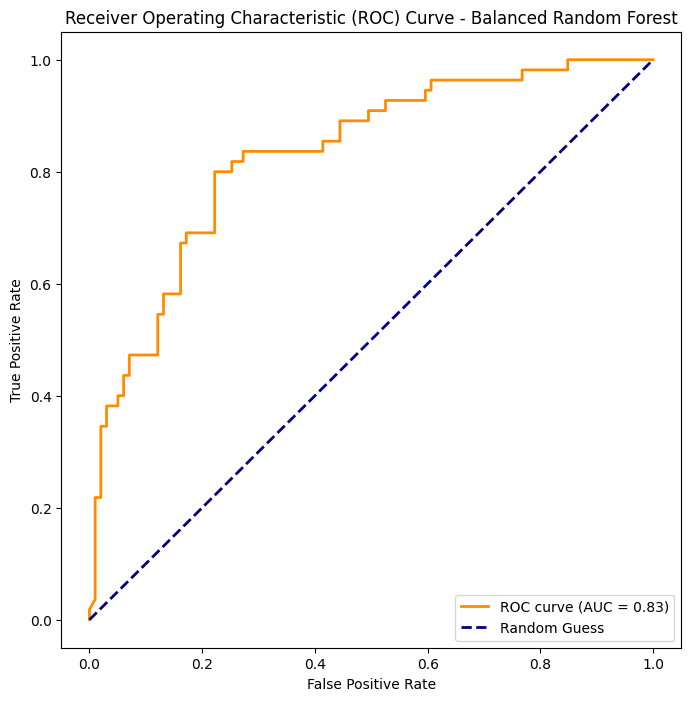

In [19]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(1, 20), 
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
}


# Create a RandomForestClassifier
rf_balance = RandomForestClassifier(random_state=42) # Class weight balanced is not required since we are using balanced set

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_balance, 
    param_distributions=param_dist, 
    n_iter=10,  # Adjust the number of iterations as needed
    cv=5,  # Adjust the number of cross-validation folds as needed
    scoring='roc_auc',  # Use 'roc_auc' for binary classification
    random_state=42
)

# Perform the search on the balanced dataset
random_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Use the best parameters to create the tuned model
tuned_rf_balance = RandomForestClassifier(**best_params, random_state=42)

# Fit the tuned model on the balanced dataset
tuned_rf_balance.fit(X_train_balanced, y_train_balanced)

# Predictions on the Training Set
y_pred_train_rf_balance_tuned = tuned_rf_balance.predict(X_train_balanced)

# Predictions on the Test Set
y_pred_rf_balance_tuned = tuned_rf_balance.predict(X_test)

# Print the evaluation metrics and the ROC curve
evaluation_metrics(y_train_balanced, y_test, X_train_balanced, X_test, tuned_rf_balance, 
                   y_pred_train_rf_balance_tuned, y_pred_rf_balance_tuned)



This seems to be the best model so far, we raised our test accuracy from 72% to 77% and our test recall from 78% to 80%. Our F1 score also increased from 67% to 72%. The performance seems to be satisfactory and with this we will close our model building activity. Lastly we will train the model on the entire dataset for future deployment. 

List of Best Parameters: {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 19}

Final Performance Metrics: 

- Training Accuracy: 0.940149625935162
- Training Precision: 0.9212410501193318
- Training Recall: 0.9625935162094763
- Training F1-Score: 0.9414634146341464
- Test Accuracy: 0.7727272727272727
- Test Precision: 0.6470588235294118
- Test Recall: 0.8
- Test F1-Score: 0.7154471544715447



### To summarize the list of steps that led to lift in the model performance were: 

- Balancing the dataset using SMOTE based approach (Recall on test set rose from 73% to 75%.)
- Hyperparameter tuning of Random Forest using randomized search (Recall on test set rose from 75% to 78%.)
- Dropping predictors that were stastically not significant (Recall on test set rose from 78% to 80%.)

### Next Steps:

- Retrain the model on the entire dataset
- Save the model joblib file for future use
- Summarize the findings from the predictive modeling activity

In [20]:
# Lastly retrain the model on the entire set for future use

X = diabetes_df[diabetes_df.columns[~diabetes_df.columns.isin(['Outcome', 'BloodPressure'])]]
y = diabetes_df['Outcome']

# Fit the final model on the entire dataset
tuned_rf_balance.fit(X, y)

#r'Data\diabetes.csv'
# Save the model to a file
model_filename = r'Model\final_rf_model.joblib'
dump(tuned_rf_balance, model_filename)

['Model\\final_rf_model.joblib']

# Part IV : Conclusion

### Key Findings

#### EDA Findings - 

1. No missing values 
2. Outliers were less than 5%. 
3. Multicollinearity - There was no multicollinearity between predictor variables (except age and pregnancies - 0.54)
4. Skewness - Most of the predictor variables were slightly skewed but did not require any transformation to gaussian as the sahpiro-wilk test p value was significant for all of them. 
5. Feature Importance - All were found to be stastically significant (Independent T-test) w.r.t to occurence of Diabetes except Blood Pressure. (Following 5 factors are significantly associated with diabetes occurence - Glucose, BMI, Age, Preganancies, DiabetesPedigreeFunction)
6. Predictor Distribution Analysis w.r.t Outcome - 
- Female patients with pregnancy in past tend to be more likely to have diabetes
- Higher glucose is associated with high likelihood of Diabetes
- Likelihood of Diabetes increases with Age
7. Dataset had class imbalance which was treated using SMOTE

#### Modeling Findings -

Key steps that improved random forest performance: 
- Balancing the dataset using SMOTE based approach (Recall on test set rose from 73% to 75%.)
- Hyperparameter tuning of Random Forest using randomized search (Recall on test set rose from 75% to 78%.)
- Dropping predictors that were stastically not significant (Recall on test set rose from 78% to 80%.)
- Random Forest, after hyperparameter tuning and feature selection, emerged as the best-performing model with a test recall of 80%.

